# Draftsheet

> First experiment and ideas

In [114]:
import sklearn
from tsai.basics import *
my_setup(sklearn)
import matplotlib.dates as mdates

os              : Linux-5.19.0-32-generic-x86_64-with-glibc2.31
python          : 3.9.2
tsai            : 0.3.6
fastai          : 2.7.11
fastcore        : 1.5.28
sklearn         : 1.2.1
torch           : 1.13.1+cu117
device          : 1 gpu (['NVIDIA GeForce RTX 3050 Ti Laptop GPU'])
cpu cores       : 14
threads per cpu : 1
RAM             : 15.32 GB
GPU memory      : [4.0] GB


In [115]:
data_path = download_data('https://sol.spacenvironment.net/jb2008/indices/SOLFSMY.TXT')
data_path

Path('/home/vscode/.fastai/archive/SOLFSMY.TXT')

In [117]:
# Read the text file into a pandas DataFrame, ignoring the lines starting with '#'
# Column names: YYYY DDD   JulianDay  F10   F81c  S10   S81c  M10   M81c  Y10   Y81c  Ssrc
df_raw = pd.read_csv(data_path, delim_whitespace=True, comment='#', header=None, 
                 names=['Year', 'DDD', 'JulianDay', 'F10', 'F81c', 'S10', 'S81c', 
                        'M10', 'M81c', 'Y10', 'Y81c', 'Ssrc'])
df_raw.head()

,Year,DDD,JulianDay,F10,F81c,S10,S81c,M10,M81c,Y10,Y81c,Ssrc
0,1997,1,2450450.0,72.4,78.0,74.0,79.2,65.4,73.8,61.9,70.7,1B11
1,1997,2,2450451.0,72.1,77.9,73.8,79.1,66.9,73.7,63.4,70.4,1B11
2,1997,3,2450452.0,73.3,77.6,75.0,79.1,70.1,73.6,64.9,70.2,1B11
3,1997,4,2450453.0,73.8,77.3,76.3,79.0,71.6,73.4,65.5,69.8,1B11
4,1997,5,2450454.0,74.4,76.9,77.6,78.9,72.4,73.3,66.7,69.6,1B11


F10, S10, M10, and Y10 (81c) have different observation and report times; to standardize reporting, all values are reported in sfu units at 12UT (Universal Time); observations are 3-times daily for F10 (20 UT used), every 5 minutes for S10 (daily average used), twice daily for M10 (7 and 16 UT), and every 1 minute for Y10 (Xrays are each minute while Lya is daily); 

For model inputs the values should be used as a daily value between 0-24 UT for a given calendar date; F10 and S10 are 1-day lagged, M10 is 2-day, and Y10 is 5-day lagged in JB2008; the 81-day centered values are used with the same respective lag times. Ssrc has 4 fields (1 for each index): 

*  0 = (F10, S10, M10, Y10) spline-filled if value or missing if no value; 
* 1 = (F10, M10, Y10) derived or measured index, (S10) SOHO/SEM; 
* 2 = (S10) TIMED/SEE v11; 
* 3 = (S10) SOHO gap (daily); 
* 4 = (S10) SOHO gap (average); 
* 5 = (F10) F10 mean (2 surrounding values), (S10) SDO/EVE; 
* 6 = (S10) GOES/EUVS fill-in, (M10) M10 mean (2 surrounding values); 
* 7 = (S10) S10 scaled to match M10 change from previous day; 
* 8 = (S10) SDO/EVE corrections and all S10 tweaked from sat 12388 delta B%, (Y10) UARS/SOLSTICE V18; 
* 9 = (S10) replace original v4.0h data for versions 4.0 and higher, (Y10) UARS/SOLSTICE v19; 
* A = (S10) TIMED/SEE solar minimum correction; 
* B = (S10) replace with original v4.0h S10 data for versions 4.0 and higher, (M10) SORCE/SOLSTICE/SIM v9; 
* C = (S10) SDO/EVE correction, (Y10) GOES XRS; 
* D = (S10) validated TIMED/SEE, (Y10) GOES XRS and SET composite LYA; 
* E = (S10) S10 composite, (Y10) SET composite LYA; 
* F = (F10, S10, M10, Y10) mean of bordering values

Acronyms:
* SOHO/SEM: Solar and Heliospheric Observatory/ Spacecraft's Solar Extreme-ultraviolet Monitor (SEM)
* SDO/EVE: Solar Dynamics Observatory/Extreme Ultraviolet Variability Experiment.
* UARS/SOLSTICE: Upper Atmosphere Research Satellite/Solar Stellar Irradiance Comparison Experiment
* SORCE/SOLSTICE/SIM: Solar Radiation and Climate Experiment/SOLSTICE/Spectral Irradiance Monitor
* GOES/XRS: Geostationary Operational Environmental Satellite/X-Ray Sensor
* "SET composite LYA" refers to the solar irradiance in the Lyman-alpha (Lyα) wavelength range, as measured by the Solar EUV Experiment Telescope (SET) onboard the Solar Radiation and Climate Experiment (SORCE) spacecraft.

This webpage contains forecasts (paid forecast) that we can use to compare to
https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2020SW002496. It's interesting
to see what they forecast from the previous data in order to try the same thing 
with the neural network

## Data preprocessing

In [116]:
# Check if there are any missing values
df_raw.isna().sum()

Year         0
DDD          0
JulianDay    0
F10          0
F81c         0
S10          0
S81c         0
M10          0
M81c         0
Y10          0
Y81c         0
Ssrc         0
Ssrc_F10     0
Ssrc_S10     0
Ssrc_M10     0
Ssrc_Y10     0
SsrcF10      0
SsrcS10      0
SsrcM10      0
SsrcY10      0
dtype: int64

In [118]:
# Convert the JulianDay column to a datetime column, and set it as index
df_raw['Date'] = pd.to_datetime(df_raw['JulianDay'], unit='D', origin='julian')
df_raw['Date'].head()
df_raw.set_index('Date', inplace=True)

In [119]:
# Distinct value of the column Ssrc
df_raw.Ssrc.unique()

array(['1B11', '5B11', '1B61', '1F11', '1B1F', '1A11', '1A61', '5A11',
       '5A61', '1F61', '1811', '1511', '1C11', '1D11', '1E11', '1E10'],
      dtype=object)

In [120]:
# Separate the Ssrc columns into four colums, one for each character of the string,
# The names of the new columns will be SsrcF10, SsrcS10, SsrcM10, and SsrcY10,
# Cast the new columns into categories. Use a loop
for i, c in enumerate('F10 S10 M10 Y10'.split()):
    df_raw[f'Ssrc_{c}'] = df_raw['Ssrc'].str[i].astype('category')
df_raw[['Ssrc_F10', 'Ssrc_S10', 'Ssrc_M10', 'Ssrc_Y10']].head()


,Ssrc_F10,Ssrc_S10,Ssrc_M10,Ssrc_Y10
Date,,,,
1997-01-01 12:00:00,1,B,1,1
1997-01-02 12:00:00,1,B,1,1
1997-01-03 12:00:00,1,B,1,1
1997-01-04 12:00:00,1,B,1,1
1997-01-05 12:00:00,1,B,1,1


In [121]:
# See the categories of the column Ssrc_S10
df_raw.Ssrc_S10.cat.categories

Index(['5', '8', 'A', 'B', 'C', 'D', 'E', 'F'], dtype='object')

Text(0.5, 1.0, 'S10 and Ssrc_S10')

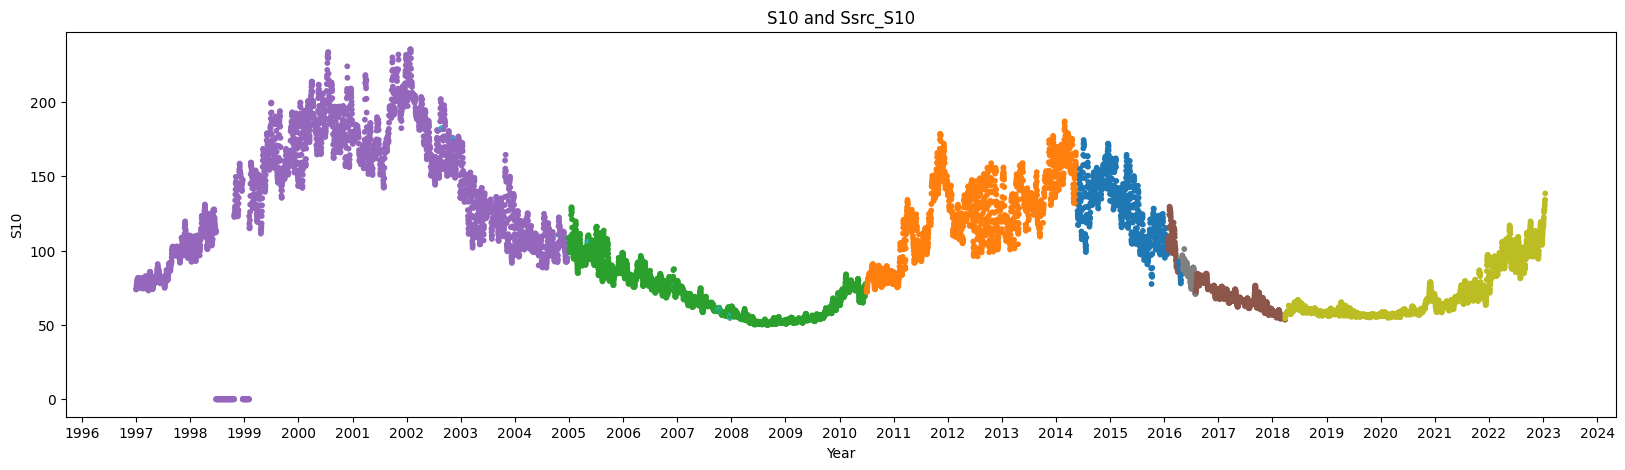

In [162]:
# Plot the variable S10. The color of the line will be determined by the value of Ssrc_S10
fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(df_raw.index, df_raw.S10, c=df_raw.Ssrc_S10.cat.codes, cmap='tab10', s=10)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_xlabel('Year')
ax.set_ylabel('S10')
ax.set_title('S10 and Ssrc_S10')
# TODO: Add a legend

TODO: How can we detected those anomalies between 1988 and 1999? Maybe the ones equal to zero

0


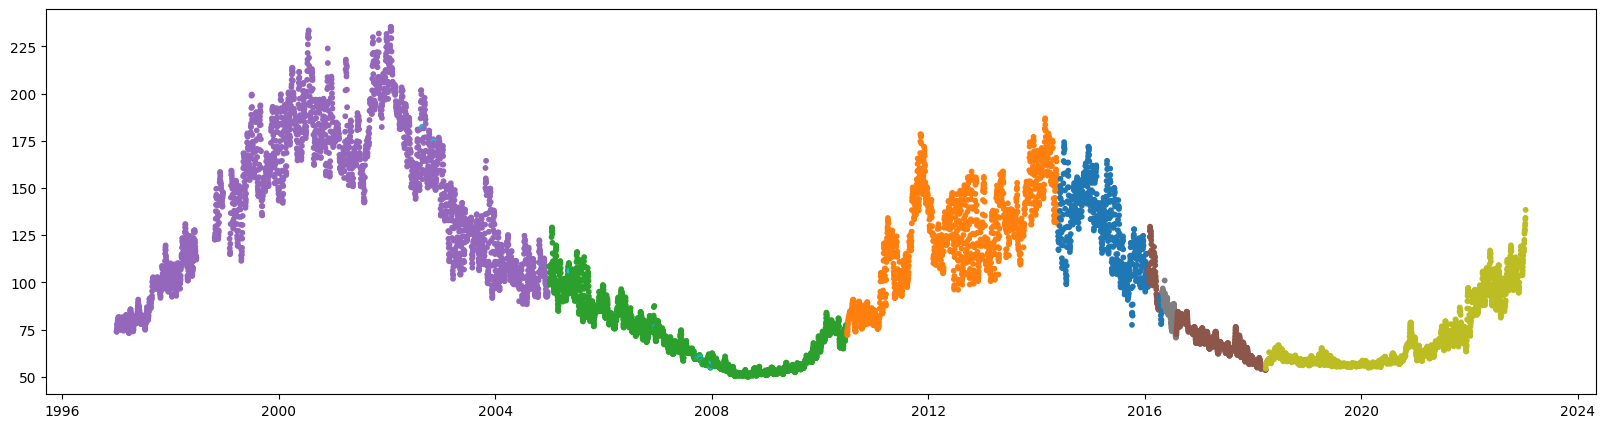

In [166]:
# Get the number of values equlas to zero in S10
print((df_raw.S10 == 0).sum())
# convert them to NA
df_raw.loc[df_raw.S10 == 0, 'S10'] = np.nan
# plot the variable S10 again
fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(df_raw.index, df_raw.S10, c=df_raw.Ssrc_S10.cat.codes, cmap='tab10', s=10)


In [174]:
datetime_col = 'Date'
freq = '1D'
data_columns = 'F10 S10 M10 Y10'.split()
imputation_method = 'ffill'

# sklearn's preprocessing pipeline
preproc_pipe = sklearn.pipeline.Pipeline([
    ('shrinker', TSShrinkDataFrame()), # shrik dataframe memory usage and set the right dtypes
    ('drop_duplicates', TSDropDuplicates(use_index=True)), # drop duplicates
    ('fill_missing', TSFillMissing(columns=data_columns, method=imputation_method, value=None)), # fill missing data (1st ffill. 2nd value=0)
], verbose=True)

df = preproc_pipe.fit_transform(df_raw)
df

Initial memory usage: 1.23 MB   
Final memory usage  : 751.70 KB  (-40.4%)
[Pipeline] .......... (step 1 of 3) Processing shrinker, total=   0.0s
[Pipeline] ... (step 2 of 3) Processing drop_duplicates, total=   0.0s
[Pipeline] ...... (step 3 of 3) Processing fill_missing, total=   0.0s


,Year,DDD,JulianDay,F10,F81c,S10,S81c,M10,M81c,Y10,Y81c,Ssrc,Ssrc_F10,Ssrc_S10,Ssrc_M10,Ssrc_Y10
Date,,,,,,,,,,,,,,,,
1997-01-01 12:00:00,1997,1,2450450.0,72.400002,78.000000,74.000000,79.199997,65.400002,73.800003,61.900002,70.699997,1B11,1,B,1,1
1997-01-02 12:00:00,1997,2,2450451.0,72.099998,77.900002,73.800003,79.099998,66.900002,73.699997,63.400002,70.400002,1B11,1,B,1,1
1997-01-03 12:00:00,1997,3,2450452.0,73.300003,77.599998,75.000000,79.099998,70.099998,73.599998,64.900002,70.199997,1B11,1,B,1,1
1997-01-04 12:00:00,1997,4,2450453.0,73.800003,77.300003,76.300003,79.000000,71.599998,73.400002,65.500000,69.800003,1B11,1,B,1,1
1997-01-05 12:00:00,1997,5,2450454.0,74.400002,76.900002,77.599998,78.900002,72.400002,73.300003,66.699997,69.599998,1B11,1,B,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-11 12:00:00,2023,11,2459956.0,188.699997,164.100006,130.000000,122.199997,180.100006,169.800003,188.399994,170.199997,1E11,1,E,1,1
2023-01-12 12:00:00,2023,12,2459957.0,204.699997,164.500000,131.199997,122.500000,179.100006,170.300003,185.800003,170.500000,1E11,1,E,1,1
2023-01-13 12:00:00,2023,13,2459958.0,201.699997,164.699997,133.399994,122.699997,176.899994,170.699997,188.399994,170.800003,1E11,1,E,1,1


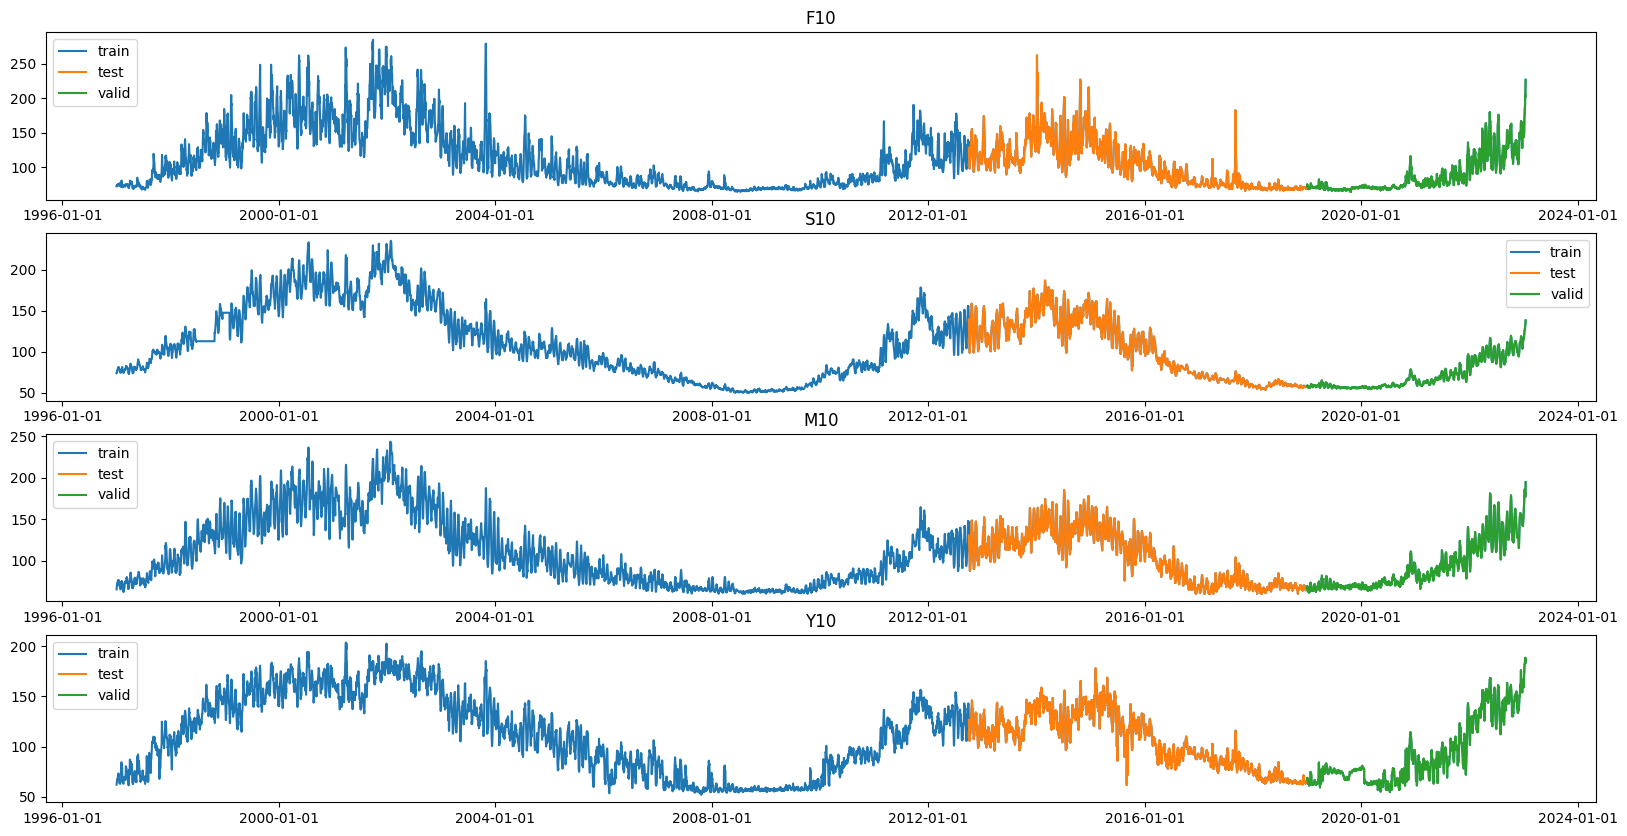

In [176]:
# In the paper by Licata et al. (2020) (https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2020SW002496),
# authors use a period from October 2012 through the end of 2018 for the benchmarking.
# Therefore, we will set the test set as the same period for our analysis, 
# using the column Date as the timestamp, from October 2012 to the end of 2018. 
# Everything before the test set will be used for training, and everything after the test set
# will be used for validation
test_start_datetime = '2012-10-01'
test_end_datetime = '2018-12-31'
valid_start_datetime = '2019-01-01'

# Plot the variables F10, S10, M10 and Y10, covering the different periods (training, test and validation)
# with different colors. Do it for the 4 variables mentioned above 
fig, ax = plt.subplots(4, 1, figsize=(20, 10))
 
for i, var in enumerate(['F10', 'S10', 'M10', 'Y10']):
    ax[i].plot(df[var], label='train')
    ax[i].plot(df[var][(df.index >= test_start_datetime) & (df.index <= test_end_datetime)],
               label='test')
    ax[i].plot(df[var][(df.index >= valid_start_datetime)], label='valid')
    ax[i].set_title(var)
    ax[i].legend()
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # format x-axis ticks
